In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")


import warnings
warnings.filterwarnings("ignore")

In [2]:
df1=pd.read_csv('/Users/pshyun2820/Downloads/archive (2)/hashtag_joebiden.csv', lineterminator='\n')
df2=pd.read_csv('/Users/pshyun2820/Downloads/archive (2)/hashtag_donaldtrump.csv', lineterminator='\n')

In [3]:
#데이터 병합
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [4]:
# 날짜 데이터를 datetime 형식으로 변환
df['created_at'] = pd.to_datetime(df['created_at'])

#날짜 데이터에서 시간 부분 제외
df['created_at'] = df['created_at'].dt.date

In [5]:
us_data = df[df['country'] == 'United States of America']
print(us_data.columns)

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')


In [6]:
rows = len(us_data)
rows

332495

In [7]:
us_data.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
2,2020-10-15,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
4,2020-10-15,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132
6,2020-10-15,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",...,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,2020-10-21 00:00:03.106963698
11,2020-10-15,1.316529e+18,"FBI Allegedly Obtained Hunter Biden Computer, ...",0.0,0.0,Twitter for Android,9.607387e+17,RLCompton,NewfoundStudio,"""There are things known and there are things u...",...,266.0,"Kentucky, USA",37.572603,-85.155141,NaN,United States of America,North America,Kentucky,KY,2020-10-21 00:00:05.696100113


In [8]:
import re

#Extract hashtags
us_data['hashtags'] = us_data['tweet'].apply(lambda x: re.findall(r'#\w+', x))

#explode -> 여러개로 만들어주는 코드
exploded_data = us_data.explode('hashtags')

#~ -> not include specific hastags
filtered_data = exploded_data[~exploded_data['hashtags'].str.lower().isin(['#trump', '#joebiden', '#biden', '#donaldtrump'])]

#size -> 각 그룹에 포함된 행의 개수 세주기 / reset index(인덱스 리셋)
hashtag_counts = filtered_data.groupby(['created_at', 'state', 'hashtags']).size().reset_index(name='count')

# Find the most frequent hashtag for each date and state
most_frequent_hashtags = hashtag_counts.loc[hashtag_counts.groupby(['created_at', 'state'])['count'].idxmax()]

print(most_frequent_hashtags)



        created_at          state          hashtags  count
39      2020-10-15        Alabama      #HunterBiden      6
145     2020-10-15         Alaska      #alaskaquinn     15
247     2020-10-15        Arizona     #KamalaHarris     34
466     2020-10-15       Arkansas        #trumplies     24
1702    2020-10-15     California        #biden2020    107
...            ...            ...               ...    ...
363177  2020-11-08       Virginia  #BidenHarris2020     42
363650  2020-11-08     Washington     #Election2020     63
363931  2020-11-08  West Virginia           #corona      5
363952  2020-11-08      Wisconsin  #BidenHarris2020     18
364159  2020-11-08        Wyoming            #votes      6

[1304 rows x 4 columns]


In [9]:
# Group by 'hashtags' and sum the counts
total_hashtag_counts = most_frequent_hashtags.groupby('hashtags')['count'].sum().reset_index()

# Sort by 'count' in descending order and take top 20
top_10_hashtags = total_hashtag_counts.sort_values(by='count', ascending=False).head(10)

print(top_10_hashtags)


                 hashtags  count
102         #Election2020  18640
88           #Debates2020   5816
43       #BidenHarris2020   3140
279              #wtpBlue   2089
62               #COVID19   1426
164                 #MAGA   1013
104          #ElectionDay   1005
207            #Trump2020    877
106  #ElectionResults2020    668
229                 #Vote    466


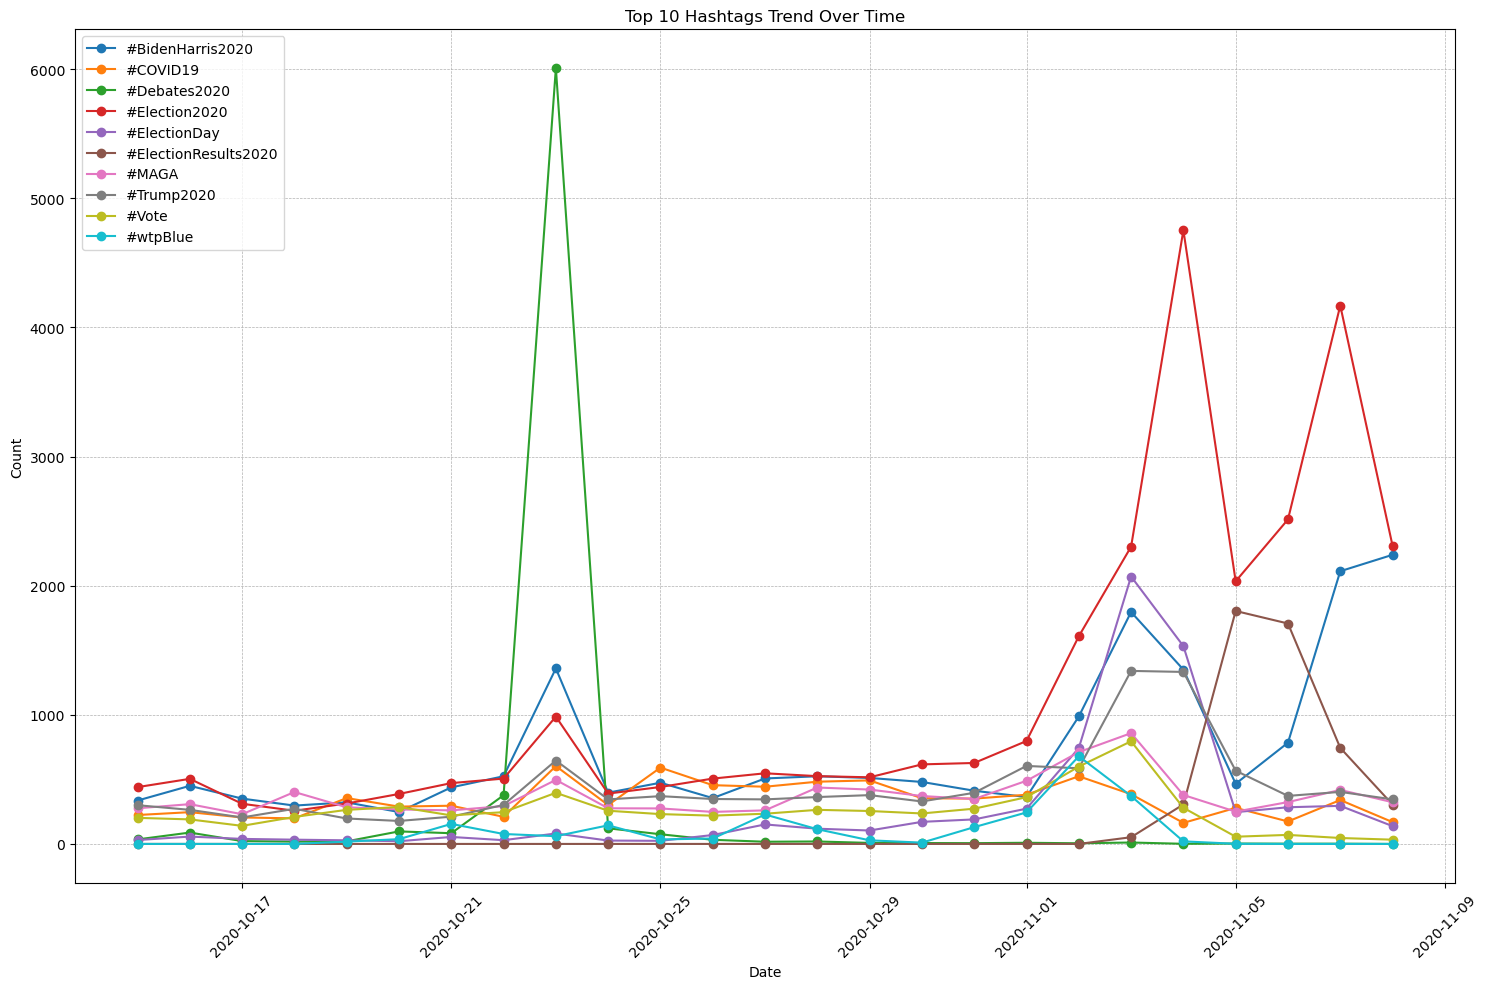

In [10]:
# List of top 20 hashtags
top_10_list = top_10_hashtags['hashtags'].tolist()

# Filter hashtag_counts for only the top 20 hashtags
top_10_data = hashtag_counts[hashtag_counts['hashtags'].isin(top_10_list)]

# Pivot the filtered data for plotting
pivot_top_10 = top_10_data.pivot_table(index='created_at', columns='hashtags', values='count', aggfunc='sum').fillna(0)

plt.figure(figsize=(15, 10))

# Loop through each hashtag in the pivoted data
for hashtag in pivot_top_10.columns:
    plt.plot(pivot_top_10.index, pivot_top_10[hashtag], label=hashtag, marker='o')

plt.legend(loc='upper left')
plt.title('Top 10 Hashtags Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


선거 시기는 11월 3일 ~ 4일

# America Value

In [11]:
# List of American values keywords
american_values = ['culture', 'American culture', 'value', 'values', 'American values', 
                   'cultural values', 'belief', 'beliefs', 'ideals', 'what we stand for', 
                   'what America stands for'
]

# Function to count the occurrences of each keyword in a tweet
def count_keywords(tweet):
    keyword_counts = {}
    lower_tweet = tweet.lower()
    for value in american_values:
        keyword_counts[value] = lower_tweet.count(value.lower())
    return keyword_counts

# Apply the function to the 'tweet' column
us_data['keyword_counts'] = us_data['tweet'].apply(count_keywords)

# Sum up the counts for each keyword
total_keyword_counts = us_data['keyword_counts'].apply(pd.Series).sum().sort_values(ascending=False)

print(total_keyword_counts)


value                      762
values                     492
culture                    343
belief                     262
beliefs                    115
ideals                      84
American values             39
American culture             5
what America stands for      4
what we stand for            1
cultural values              0
dtype: int64


In [18]:
# List of American values keywords
american_values = ['culture', 'American culture', 'value', 'values', 'American values', 'cultural values', 'belief', 'beliefs', 'ideals', 'what we stand for', 'what America stands for'
]

# Function to count the occurrences of each keyword in a tweet
def count_keywords(tweet):
    keyword_counts = {}
    lower_tweet = tweet.lower()
    for value in american_values:
        keyword_counts[value] = lower_tweet.count(value.lower())
    return keyword_counts

# Apply the function to the 'tweet' column
us_data['keyword_counts'] = us_data['tweet'].apply(count_keywords)

# Sum up the counts for each keyword
total_keyword_counts = us_data['keyword_counts'].apply(pd.Series).sum().sort_values(ascending=False)

print(total_keyword_counts)


value                      762
values                     492
culture                    343
belief                     262
beliefs                    115
ideals                      84
American values             39
American culture             5
what America stands for      4
what we stand for            1
dtype: int64


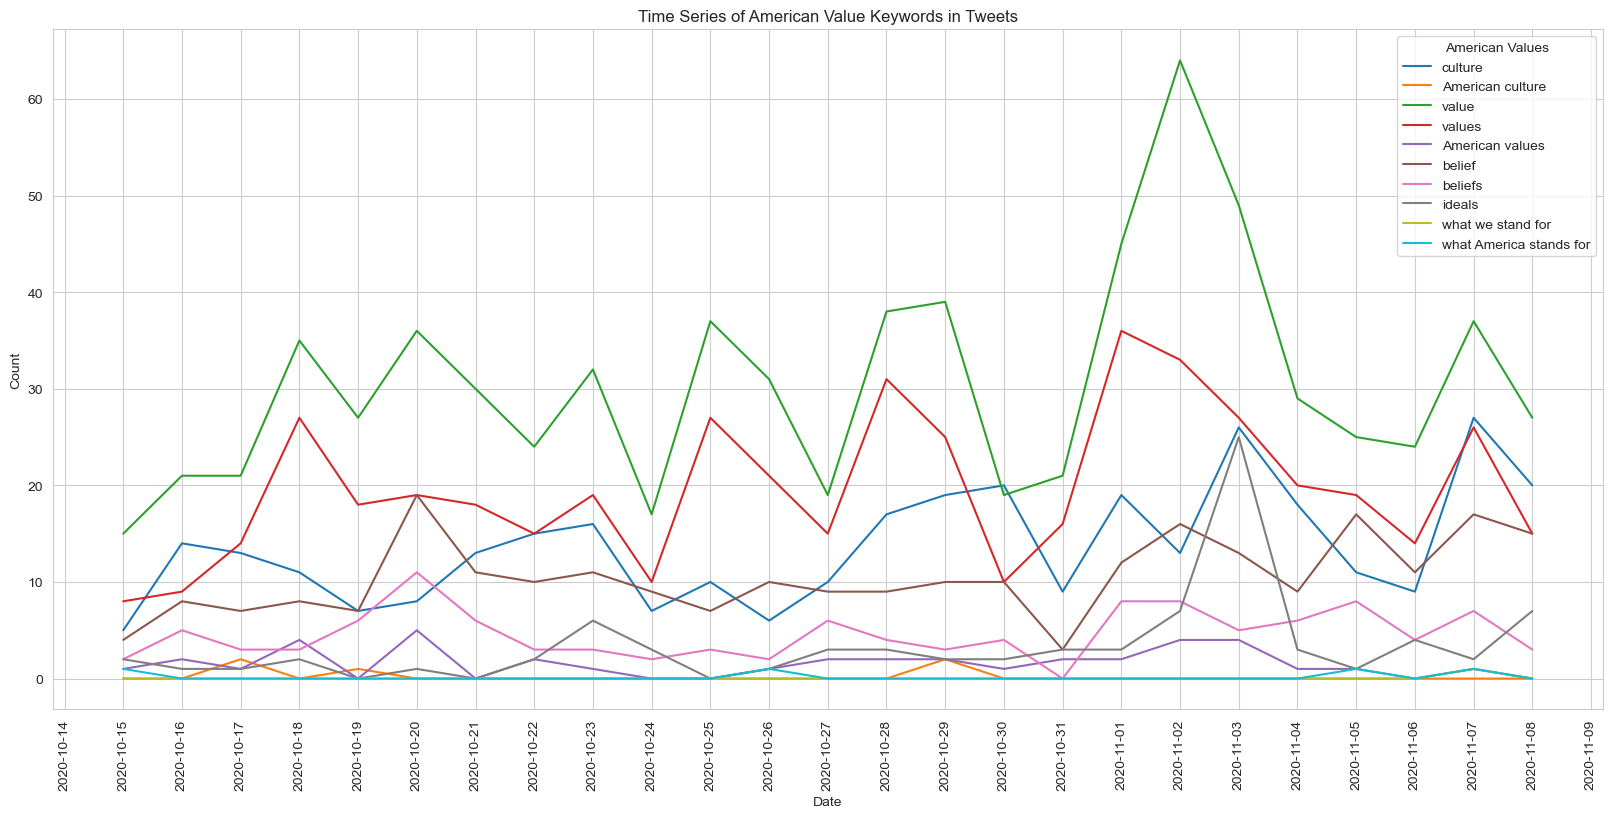

In [21]:
#### import matplotlib.dates as mdates

datewise_counts = us_data.groupby('created_at')['tweet'].sum().apply(count_keywords).apply(pd.Series)

# Define unique colors for each keyword
colors = sns.color_palette("tab10", len(american_values))

sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

for index, value in enumerate(american_values):
    plt.plot(datewise_counts.index, datewise_counts[value], label=value, color=colors[index])

plt.title('Time Series of American Value Keywords in Tweets')
plt.xlabel('Date')
plt.ylabel('Count')

# Set x-axis major locator to every single day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis major formatter to show the date in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the date labels for better legibility
plt.xticks(rotation=90)

# Increase the bottom of the subplot to make the x-axis labels fit nicely
plt.subplots_adjust(bottom=0.2)

# Display the legend
plt.legend(title='American Values', loc='upper right')

# Display the plot
plt.show()



## Add more American_Values

### "America" -> "The States", "The U.S.", "Uncle Sam", "The Land of Opportunity", "merica"

### "American" -> "Yankee", "USAmade", "AmericanPride"

### "Americans" -> "People of USA", "U.S. citizens", "American People", "USCitizens"

### "USA" -> "The United States", "The U.S. of A.", "USAstrong", "United States of America", "America the Beautiful"

### "country" -> "homeland", "motherland", "Nation love", "my country"

### "nation" -> "state", "country", "the republic"

### "culture" -> "way of life", "lifestyle", "heritage", "melting pot", "cultural diversity"

### "cultural" -> "ethnical", "social", "artistic"

### "value" -> "principle", "standard", "morality", "what we stand for"

### "values" -> "principles", "moral values", "ethics", "family values", "ethical living"

### "belief" -> "conviction", "faith", "credo", "American Faith", "personal beliefs", "believe in America"

### "beliefs" -> "Shared Beliefs", "diverse beliefs"

### "ideals" -> "American ideals", "pursuit of happiness", "dream big"


In [21]:
# List of American values keywords
american_values_2 = ['America', 'the states', 'the u.s.', 'uncle sam', 'the land of opportunity', 'merica', 'American', 'yankee', 'usa made', 'american pride', 'people of usa', 'u.s. citizens', 'american people', 'us citizens' 'Americans', 'USA', 'country', 'homeland', 'motherland', 'nation love', 'my country', 'nation', 'state', 'the republic', 'culture', 'way of life', 'lifestyle', 'heritage', 'melting pot', 'cultural diversity', 'diversity', 'cultural', 'ethical', 'social', 'artistic', 'value', 'principle', 'standard', 'morality', 'what we stand for', 'values', 'principles', 'moral values', 'family values', 'ethical living', 'belief', 'conviction', 'faith', 'credo', 'american faith', 'personal beliefs', 'believe in america', 'beliefs', 'shared beliefs', 'diverse beliefs', 'ideals', 'american ideals', 'pursuit of happpiness', 'dream big'
]

# Function to count the occurrences of each keyword in a tweet
def count_keywords(tweet):
    keyword_counts = {}
    lower_tweet = tweet.lower()
    for value in american_values_2:
        keyword_counts[value] = lower_tweet.count(value.lower())
    return keyword_counts

# Apply the function to the 'tweet' column
us_data['keyword_counts'] = us_data['tweet'].apply(count_keywords)

# Sum up the counts for each keyword
total_keyword_counts = us_data['keyword_counts'].apply(pd.Series).sum().sort_values(ascending=False)

print(total_keyword_counts)


merica                     57262
America                    57104
American                   16737
state                      15449
USA                        14899
country                     9758
nation                      9252
social                      4724
american people             1517
faith                       1322
value                        762
the republic                 686
the u.s.                     605
values                       492
culture                      343
standard                     304
the states                   284
belief                       262
diversity                    191
principle                    174
ethical                      166
principles                   126
my country                   124
beliefs                      115
yankee                       104
heritage                      96
homeland                      95
morality                      92
ideals                        84
conviction                    83
lifestyle 

In [22]:
print(total_keyword_counts.head(30))

merica             57262
America            57104
American           16737
state              15449
USA                14899
country             9758
nation              9252
social              4724
american people     1517
faith               1322
value                762
the republic         686
the u.s.             605
values               492
culture              343
standard             304
the states           284
belief               262
diversity            191
principle            174
ethical              166
principles           126
my country           124
beliefs              115
yankee               104
heritage              96
homeland              95
morality              92
ideals                84
conviction            83
dtype: int64


# 2016 data / Blue and Red / Vertical and Horizontal

In [23]:
import pandas as pd

data = pd.read_csv('/Users/pshyun2820/Desktop/Business Research/State_level_data.csv')

state_level_data = pd.DataFrame(data)

blue_states = state_level_data[state_level_data['RvB2016'] == 0]['States'].tolist()
red_states = state_level_data[state_level_data['RvB2016'] == 1]['States'].tolist()


## Blue State = 0 / Red State = 1

In [24]:
print("Blue states:", blue_states)

Blue states: ['California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Minnesota', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 'Rhode Island', 'Vermont', 'Virginia', 'Washington']


In [25]:
print("Red states:", red_states)

Red states: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming']


## change data

In [26]:
# Reading the data
df1 = pd.read_csv('/Users/pshyun2820/Downloads/archive (2)/hashtag_joebiden.csv', lineterminator='\n')
df2 = pd.read_csv('/Users/pshyun2820/Downloads/archive (2)/hashtag_donaldtrump.csv', lineterminator='\n')

# Concatenating the data
df = pd.concat([df1, df2], axis=0, ignore_index=True)

# Lists of blue and red states
blue_states_list = ['California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Minnesota', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 'Rhode Island', 'Vermont', 'Virginia', 'Washington']

red_states_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming']

# Mapping the states to 'blue' or 'red'
def map_state_to_color(state):
    if state in blue_states_list:
        return 'blue'
    elif state in red_states_list:
        return 'red'
    else:
        return None  # if not in either list, return None

df['state_color'] = df['state'].apply(map_state_to_color)


In [27]:
# 날짜 데이터를 datetime 형식으로 변환
df['created_at'] = pd.to_datetime(df['created_at'])

#날짜 데이터에서 시간 부분 제외
df['created_at'] = df['created_at'].dt.date

In [28]:
#state_color 없는 나라들 삭제
df = df[df['state_color'].notnull()]

## Vertical Values

Vertical Values
: security, secure, safety, order, conform, honor, tradition, customs, religion, religious, devout, Christian, status, prestige, prestigious, follow, leader, best, success, achievement, competent, competence, ambition, ambitious, capable, capability, influence, influential

In [30]:
# List of American values keywords
vertical_values = ['security', 'secure', 'safety', 'order', 'conform', 'honor', 'best', 'tradition', 'customs', 'religion', 'religious', 'devout', 'Christian', 'status', 'prestige', 'prestigious', 'follow', 'leader', 'success', 'achievement', 'competent', 'competence', 'ambition', 'ambitious', 'capable', 'capability', 'influence', 'influential']

def extract_keywords(tweet):
    keywords_present = [keyword for keyword in vertical_values if keyword in tweet.lower()]
    return keywords_present


In [31]:
# List of American values keywords
df['vertical_keywords'] = df['tweet'].apply(extract_keywords)

# Explode the DataFrame on the 'keywords' column
exploded_data = df.explode('vertical_keywords')

# Group by 'created_at', 'state', and 'keywords', then count occurrences
#keyword_counts = exploded_data.groupby(['created_at', 'state_color', 'vertical_keywords']).size().reset_index(name='count')

# Find the most frequent keyword for each date and state
#most_frequent_keywords = keyword_counts.loc[keyword_counts.groupby(['created_at', 'state_color'])['count'].idxmax()]

#print(most_frequent_keywords)



In [32]:
keyword_counts = exploded_data.groupby(['created_at', 'state_color', 'vertical_keywords']).size().reset_index(name='count')

print(keyword_counts)

     created_at state_color vertical_keywords  count
0    2020-10-15        blue              best     50
1    2020-10-15        blue           capable      5
2    2020-10-15        blue        competence     10
3    2020-10-15        blue         competent      9
4    2020-10-15        blue           conform      1
..          ...         ...               ...    ...
970  2020-11-08         red            secure      2
971  2020-11-08         red          security     15
972  2020-11-08         red            status      5
973  2020-11-08         red           success     15
974  2020-11-08         red         tradition      7

[975 rows x 4 columns]


In [33]:
# 'count' 열을 기준으로 내림차순 정렬
sorted_keyword_counts = keyword_counts.sort_values(by='count', ascending=False)

# 상위 30개의 결과 출력
top_30_keywords = sorted_keyword_counts.head(30)
print(top_30_keywords)

#top_30_keywords.to_csv('top_30_keywords.csv')

# 또는 스프레드시트 파일로 저장
#import openpyxl

#top_30_keywords.to_excel('/Users/pshyun2820/Desktop/Business Research/vertical(contain_date)_top_30_keywords.xlsx', engine='openpyxl')


     created_at state_color vertical_keywords  count
905  2020-11-07        blue            leader    246
896  2020-11-07        blue              best    214
864  2020-11-06        blue            follow    203
944  2020-11-08        blue            leader    194
141  2020-10-18         red          security    192
902  2020-11-07        blue            follow    176
302  2020-10-23        blue              best    172
311  2020-10-23        blue            leader    171
322  2020-10-23         red              best    160
708  2020-11-02        blue            leader    156
936  2020-11-08        blue              best    154
647  2020-10-31         red            leader    152
736  2020-11-02         red          security    152
961  2020-11-08         red            follow    142
312  2020-10-23        blue             order    141
867  2020-11-06        blue            leader    138
355  2020-10-24        blue             order    138
916  2020-11-07         red              best 

In [34]:
# 'vertical_keywords' 별로 합계 카운트 계산
keyword_totals = keyword_counts.groupby(['state_color','vertical_keywords'])['count'].sum()

# 내림차순으로 정렬하여 상위 30개 선택
top_30_keyword_totals = keyword_totals.sort_values(ascending=False).head(30)

print(top_30_keyword_totals)

#top_30_keyword_totals.to_csv('top_30_keywords.csv')

# 또는 스프레드시트 파일로 저장
#import openpyxl

#top_30_keyword_totals.to_excel('/Users/pshyun2820/Desktop/Business Research/vertical_top_30_keywords.xlsx', engine='openpyxl')

state_color  vertical_keywords
blue         leader               2786
             follow               2191
             best                 2026
red          leader               1901
blue         order                1775
red          follow               1608
             best                 1589
blue         security             1272
red          order                1181
             security             1043
blue         honor                 482
             success               424
red          honor                 382
blue         competent             318
             influence             297
             competence            291
red          secure                263
             success               260
blue         safety                253
red          competent             228
             safety                221
blue         secure                211
red          influence             208
             competence            184
blue         capable             

In [35]:
#import datetime
#oct_15_data_1 = keyword_counts[keyword_counts['created_at'] == datetime.date(2020, 10, 15)]
#print(oct_15_data_1)

In [36]:
summed_keywords = keyword_counts.groupby(['created_at','state_color'])['count'].sum().reset_index()
print(summed_keywords)

    created_at state_color  count
0   2020-10-15        blue    337
1   2020-10-15         red    251
2   2020-10-16        blue    565
3   2020-10-16         red    373
4   2020-10-17        blue    398
5   2020-10-17         red    243
6   2020-10-18        blue    380
7   2020-10-18         red    488
8   2020-10-19        blue    395
9   2020-10-19         red    261
10  2020-10-20        blue    369
11  2020-10-20         red    252
12  2020-10-21        blue    455
13  2020-10-21         red    268
14  2020-10-22        blue    501
15  2020-10-22         red    342
16  2020-10-23        blue    926
17  2020-10-23         red    655
18  2020-10-24        blue    468
19  2020-10-24         red    290
20  2020-10-25        blue    386
21  2020-10-25         red    279
22  2020-10-26        blue    442
23  2020-10-26         red    390
24  2020-10-27        blue    443
25  2020-10-27         red    356
26  2020-10-28        blue    490
27  2020-10-28         red    404
28  2020-10-29

In [37]:
summed_keywords.rename(columns={'count': 'sum'}, inplace=True)

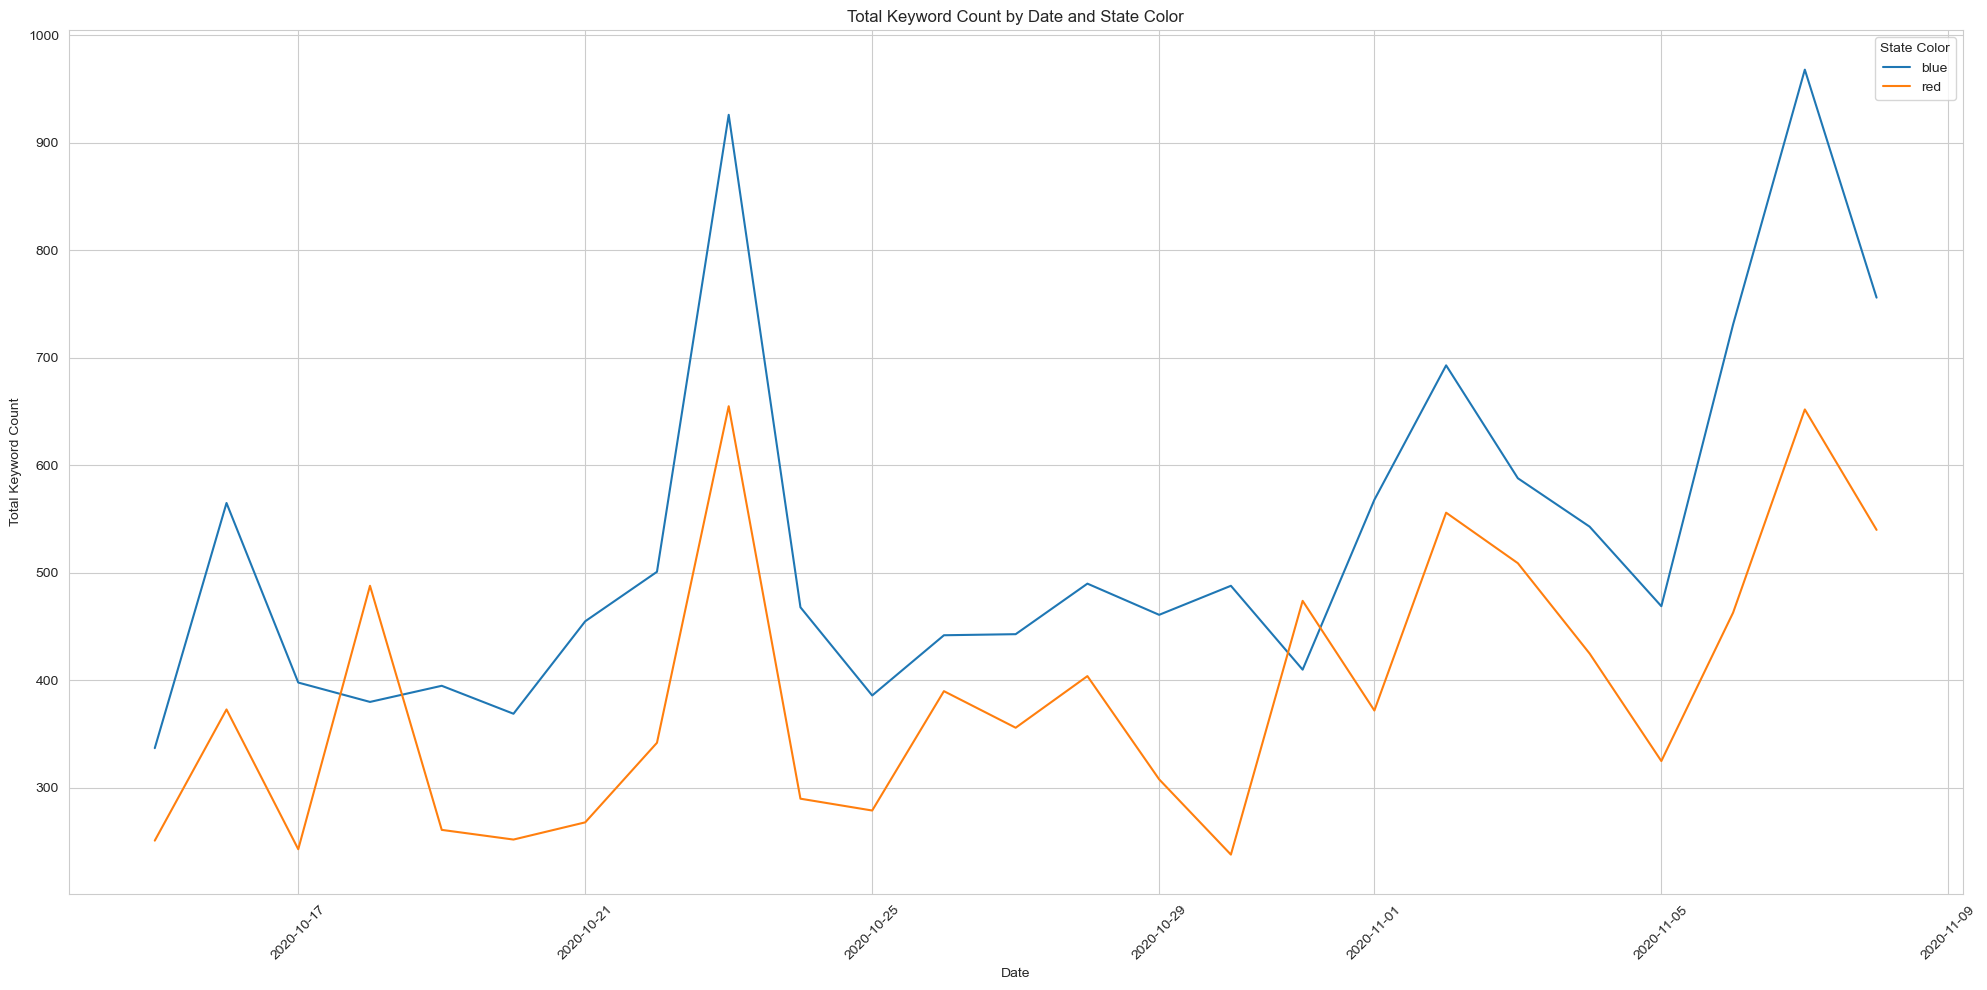

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the scatter plot
sns.lineplot(data=summed_keywords, x='created_at', y='sum', hue='state_color')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Keyword Count')
plt.title('Total Keyword Count by Date and State Color')
plt.xticks(rotation=45)
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


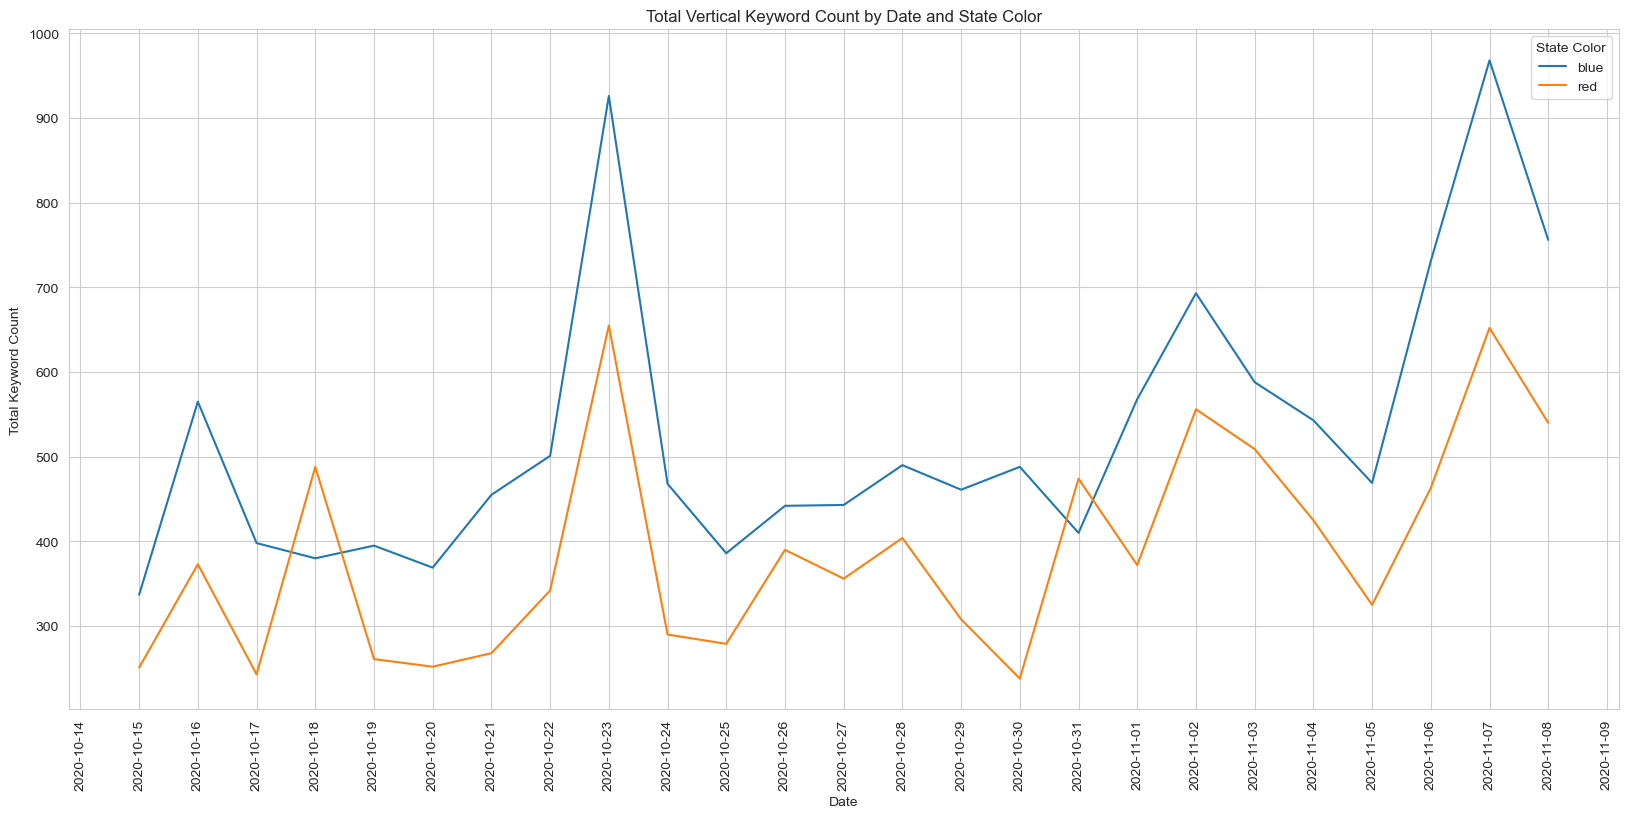

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the line plot
sns.lineplot(data=summed_keywords, x='created_at', y='sum', hue='state_color')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Keyword Count')
plt.title('Total Vertical Keyword Count by Date and State Color')

# Set x-axis major locator to every single day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis major formatter to show the date in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the date labels for better legibility
plt.xticks(rotation=90)

# Increase the bottom of the subplot to make the x-axis labels fit nicely
plt.subplots_adjust(bottom=0.2)

# Display the legend
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.show()


## Horizontal Values

Horizontal values: equality, equity, inequality, inequity, equal, justice, egalitarian, uniqueness, differences, helpful, forgiving, understanding, appreciate, appreciation, appreciating, tolerance, tolerant, welfare, nature, environmental, peace, peaceful, unity, united


In [40]:
# List of American values keywords
horizontal_values = ['equality', 'equity', 'inequality', 'inequity', 'equal', 'justice', 'egalitarian', 'uniqueness', 'differences', 'helpful', 'forgiving', 'understanding', 'appreciate', 'appreciation', 'appreciating', 'tolerance', 'tolerant', 'welfare', 'nature', 'environmental', 'peace', 'peaceful', 'unity', 'united']

def extract_keywords_2(tweet):
    keywords_present_1 = [keyword for keyword in horizontal_values if keyword in tweet.lower()]
    return keywords_present_1


In [41]:
# List of American values keywords
df['horizontal_keywords'] = df['tweet'].apply(extract_keywords_2)

# Explode the DataFrame on the 'keywords' column
exploded_data = df.explode('horizontal_keywords')

# Group by 'created_at', 'state', and 'keywords', then count occurrences
#keyword_counts = exploded_data.groupby(['created_at', 'state_color', 'horizontal_keywords']).size().reset_index(name='count')

# Find the most frequent keyword for each date and state
#most_frequent_keywords = keyword_counts.loc[keyword_counts.groupby(['created_at', 'state_color'])['count'].idxmax()]

#print(most_frequent_keywords)



In [42]:
keyword_counts_2 = exploded_data.groupby(['created_at', 'state_color', 'horizontal_keywords']).size().reset_index(name='count')

print(keyword_counts_2)

     created_at state_color horizontal_keywords  count
0    2020-10-15        blue          appreciate      2
1    2020-10-15        blue         differences      7
2    2020-10-15        blue       environmental      2
3    2020-10-15        blue               equal     14
4    2020-10-15        blue            equality      4
..          ...         ...                 ...    ...
837  2020-11-08         red            tolerant      3
838  2020-11-08         red       understanding     10
839  2020-11-08         red              united    142
840  2020-11-08         red               unity    126
841  2020-11-08         red             welfare      3

[842 rows x 4 columns]


In [43]:
# 'count' 열을 기준으로 내림차순 정렬
sorted_keyword_counts_2 = keyword_counts_2.sort_values(by='count', ascending=False)

# 상위 30개의 결과 출력
top_30_keywords_2 = sorted_keyword_counts_2.head(30)

print(top_30_keywords_2)

#top_30_keywords_2.to_csv('top_30_keywords_2.csv')

# 또는 스프레드시트 파일로 저장
#import openpyxl

#op_30_keywords_2.to_excel('/Users/pshyun2820/Desktop/Business Research/horizontal(contain_date)_top_30_keywords.xlsx', engine='openpyxl')

     created_at state_color horizontal_keywords  count
783  2020-11-07        blue              united    679
801  2020-11-07         red              united    383
820  2020-11-08        blue              united    269
423  2020-10-27         red             justice    231
622  2020-11-02         red             justice    223
586  2020-11-01         red             justice    193
414  2020-10-27        blue              united    177
278  2020-10-23        blue              united    173
821  2020-11-08        blue               unity    170
113  2020-10-18        blue              united    150
839  2020-11-08         red              united    142
409  2020-10-27        blue             justice    142
784  2020-11-07        blue               unity    141
683  2020-11-04        blue              united    137
279  2020-10-23        blue               unity    136
840  2020-11-08         red               unity    126
749  2020-11-06        blue              united    125
570  2020-

In [44]:
# 'horizontal_keywords' 별로 합계 카운트 계산
keyword_totals_2 = keyword_counts_2.groupby(['state_color','horizontal_keywords' ])['count'].sum()

# 내림차순으로 정렬하여 상위 30개 선택
top_30_keyword_totals_3 = keyword_totals_2.sort_values(ascending=False).head(30)

print(top_30_keyword_totals_3)

#top_30_keyword_totals_3.to_csv('top_30_keywords_3.csv')

# 또는 스프레드시트 파일로 저장
#import openpyxl

#top_30_keyword_totals_3.to_excel('/Users/pshyun2820/Desktop/Business Research/horizontal_top_30_keywords.xlsx', engine='openpyxl')


state_color  horizontal_keywords
blue         united                 3242
red          justice                1739
             united                 1502
blue         unity                  1431
             justice                1240
red          unity                  1098
blue         peace                  1074
red          peace                   770
             nature                  573
blue         equal                   529
             peaceful                323
red          equal                   309
blue         equality                294
red          peaceful                264
blue         nature                  212
red          equality                162
blue         environmental           158
             appreciate              140
             differences             119
red          appreciate              109
blue         understanding           109
red          understanding            89
blue         equity                   85
red          environment

In [45]:
summed_keywords_2 = keyword_counts_2.groupby(['created_at','state_color'])['count'].sum().reset_index()
print(summed_keywords_2)

    created_at state_color  count
0   2020-10-15        blue    312
1   2020-10-15         red    187
2   2020-10-16        blue    371
3   2020-10-16         red    254
4   2020-10-17        blue    240
5   2020-10-17         red    169
6   2020-10-18        blue    295
7   2020-10-18         red    109
8   2020-10-19        blue    248
9   2020-10-19         red    155
10  2020-10-20        blue    281
11  2020-10-20         red    193
12  2020-10-21        blue    250
13  2020-10-21         red    243
14  2020-10-22        blue    236
15  2020-10-22         red    200
16  2020-10-23        blue    605
17  2020-10-23         red    439
18  2020-10-24        blue    263
19  2020-10-24         red    229
20  2020-10-25        blue    272
21  2020-10-25         red    179
22  2020-10-26        blue    223
23  2020-10-26         red    229
24  2020-10-27        blue    446
25  2020-10-27         red    404
26  2020-10-28        blue    252
27  2020-10-28         red    223
28  2020-10-29

In [46]:
summed_keywords_2.rename(columns={'count': 'sum'}, inplace=True)

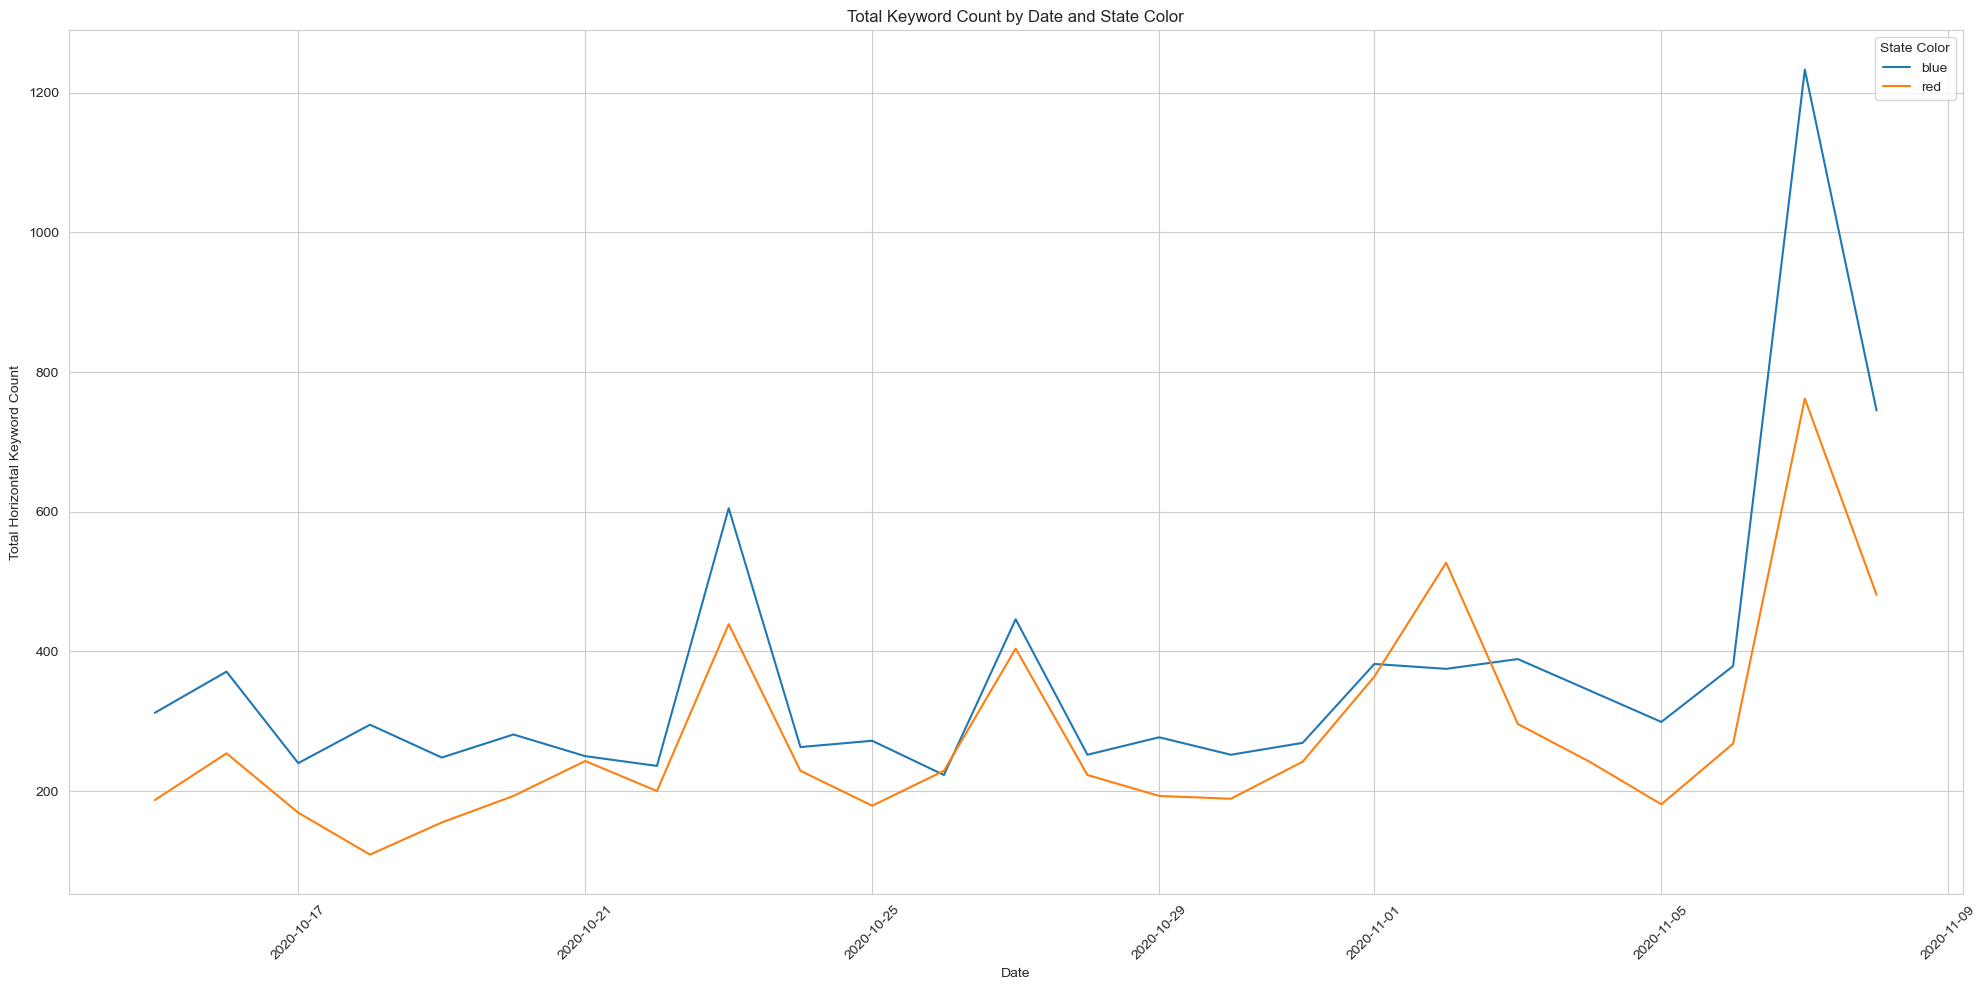

In [47]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the scatter plot
sns.lineplot(data=summed_keywords_2, x='created_at', y='sum', hue='state_color')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Horizontal Keyword Count')
plt.title('Total Keyword Count by Date and State Color')
plt.xticks(rotation=45)
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


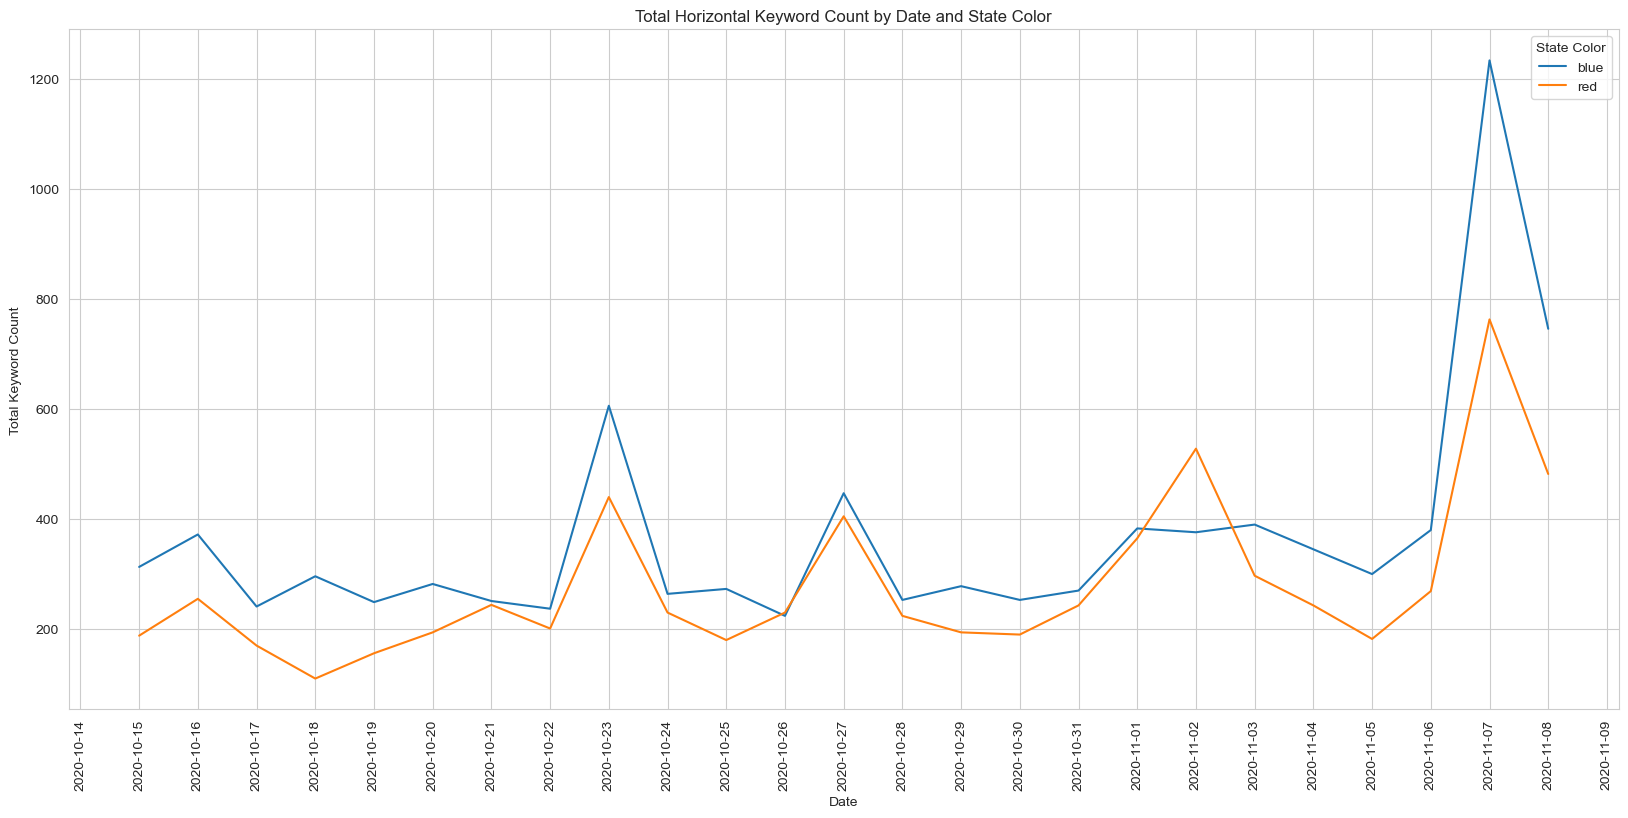

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the line plot
sns.lineplot(data=summed_keywords_2, x='created_at', y='sum', hue='state_color')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Keyword Count')
plt.title('Total Horizontal Keyword Count by Date and State Color')

# Set x-axis major locator to every single day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis major formatter to show the date in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the date labels for better legibility
plt.xticks(rotation=90)

# Increase the bottom of the subplot to make the x-axis labels fit nicely
plt.subplots_adjust(bottom=0.2)

# Display the legend
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.show()


# Graph 3 : blue / red / swings (2004~2016)

In [49]:
data = pd.read_csv('/Users/pshyun2820/Desktop/Business Research/State_level_data.csv')

state_level_data = pd.DataFrame(data)

state_level_data['RvB_Sum'] = state_level_data['RvB2004'] + state_level_data['RvB2008'] + state_level_data['RvB2012'] +state_level_data['RvB2016']

# Identify blue, red, and swing states
blue_states = state_level_data[state_level_data['RvB_Sum'] == 0]['States'].tolist()
red_states = state_level_data[state_level_data['RvB_Sum'] == 4]['States'].tolist()
swing_states = state_level_data[(state_level_data['RvB_Sum'] != 0) & (state_level_data['RvB_Sum'] != 4)]['States'].tolist()

print("Blue States:", blue_states)
print("\nRed States:", red_states)
print("\nSwing States:", swing_states)

Blue States: ['California', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Minnesota', 'New Hampshire', 'New Jersey', 'New York', 'Oregon', 'Rhode Island', 'Vermont', 'Washington']

Red States: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Georgia', 'Idaho', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Dakota', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wyoming']

Swing States: ['Colorado', 'Florida', 'Indiana', 'Iowa', 'Michigan', 'Nevada', 'New Mexico', 'North Carolina', 'Ohio', 'Pennsylvania', 'Virginia', 'Wisconsin']


In [50]:
blue_states_list = ['California', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Minnesota', 'New Hampshire', 'New Jersey', 'New York', 'Oregon', 'Rhode Island', 'Vermont', 'Washington']
red_states_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Georgia', 'Idaho', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Dakota', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wyoming']
swing_states_list = ['Colorado', 'Florida', 'Indiana', 'Iowa', 'Michigan', 'Nevada', 'New Mexico', 'North Carolina', 'Ohio', 'Pennsylvania', 'Virginia', 'Wisconsin']
# Mapping the states to 'blue' or 'red'
def map_state_to_color(state):
    if state in blue_states_list:
        return 'blue'
    elif state in red_states_list:
        return 'red'
    elif state in swing_states_list:
        return 'swing'
    else:
        return None  # if not in either list, return None

df['state_color_2'] = df['state'].apply(map_state_to_color)

In [51]:
# 날짜 데이터를 datetime 형식으로 변환
df['created_at'] = pd.to_datetime(df['created_at'])

#날짜 데이터에서 시간 부분 제외
df['created_at'] = df['created_at'].dt.date

In [52]:
df

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,city,country,continent,state,state_code,collected_at,state_color,vertical_keywords,horizontal_keywords,state_color_2
0,2020-10-15,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,red,[],[],swing
2,2020-10-15,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,red,[],[],red
4,2020-10-15,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,blue,[],[],blue
6,2020-10-15,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",...,Chicago,United States of America,North America,Illinois,IL,2020-10-21 00:00:03.106963698,blue,[],[],blue
11,2020-10-15,1.316529e+18,"FBI Allegedly Obtained Hunter Biden Computer, ...",0.0,0.0,Twitter for Android,9.607387e+17,RLCompton,NewfoundStudio,"""There are things known and there are things u...",...,NaN,United States of America,North America,Kentucky,KY,2020-10-21 00:00:05.696100113,red,[],[],red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747779,2020-11-08,1.325589e+18,@DonaldJTrumpJr Being a #tRump you are intimat...,0.0,0.0,Twitter for iPad,1.237758e+18,U N Known,pirkka2,Truth will save the world - not tRump. 🌎 VOTE ...,...,NaN,United States of America,North America,New Jersey,NJ,2020-11-09 17:47:55.744839,blue,[],[],blue
1747781,2020-11-08,1.325589e+18,Have you know decency #Trump @GOP? Do you kno...,3.0,0.0,Twitter Web App,4.835231e+07,"Linda ""I Voted for Biden"" Kenney Baden",KenneyBaden,"TrialLawyer https://t.co/1C0kKESSUC, Played by...",...,New York,United States of America,North America,New York,NY,2020-11-09 17:47:55.833725,blue,[],[],blue
1747783,2020-11-08,1.325589e+18,LIONZ DEN PRESENTS TO YOU \n\n“THE WHITE OBAMA...,1.0,0.0,Twitter for Android,9.868225e+17,IUIC Minnesota,IUICMinnesota,NaN,...,NaN,United States of America,North America,Minnesota,MN,2020-11-09 17:47:55.847439,blue,[],[],blue
1747786,2020-11-08,1.325589e+18,#Trump #Patriots #MAGA2020 https://t.co/2A8Fnm...,0.0,0.0,Twitter for Android,1.296581e+18,🍿🍷••HellWorld••🍷🍿,HellWor09724785,NaN,...,NaN,United States of America,North America,Texas,TX,2020-11-09 17:47:55.939901,red,[],[],red


## Vertical Values

In [53]:
df['vertical_keywords'] = df['tweet'].apply(extract_keywords)

# Explode the DataFrame on the 'keywords' column
exploded_data = df.explode('vertical_keywords')

keyword_counts = exploded_data.groupby(['created_at', 'state_color_2', 'vertical_keywords']).size().reset_index(name='count')

print(keyword_counts)

      created_at state_color_2 vertical_keywords  count
0     2020-10-15          blue              best     46
1     2020-10-15          blue           capable      4
2     2020-10-15          blue        competence     10
3     2020-10-15          blue         competent      9
4     2020-10-15          blue           conform      1
...          ...           ...               ...    ...
1351  2020-11-08         swing            secure      1
1352  2020-11-08         swing          security      8
1353  2020-11-08         swing            status      2
1354  2020-11-08         swing           success     13
1355  2020-11-08         swing         tradition      1

[1356 rows x 4 columns]


In [54]:
summed_keywords = keyword_counts.groupby(['created_at', 'state_color_2'])['count'].sum().reset_index(name='sum')
print(summed_keywords)

    created_at state_color_2  sum
0   2020-10-15          blue  314
1   2020-10-15           red  138
2   2020-10-15         swing  136
3   2020-10-16          blue  511
4   2020-10-16           red  184
..         ...           ...  ...
70  2020-11-07           red  318
71  2020-11-07         swing  436
72  2020-11-08          blue  679
73  2020-11-08           red  244
74  2020-11-08         swing  373

[75 rows x 3 columns]


In [55]:
summi_keywords = keyword_counts.groupby('state_color_2')['count'].sum()
print(summi_keywords)

state_color_2
blue     12147
red       5018
swing     5779
Name: count, dtype: int64


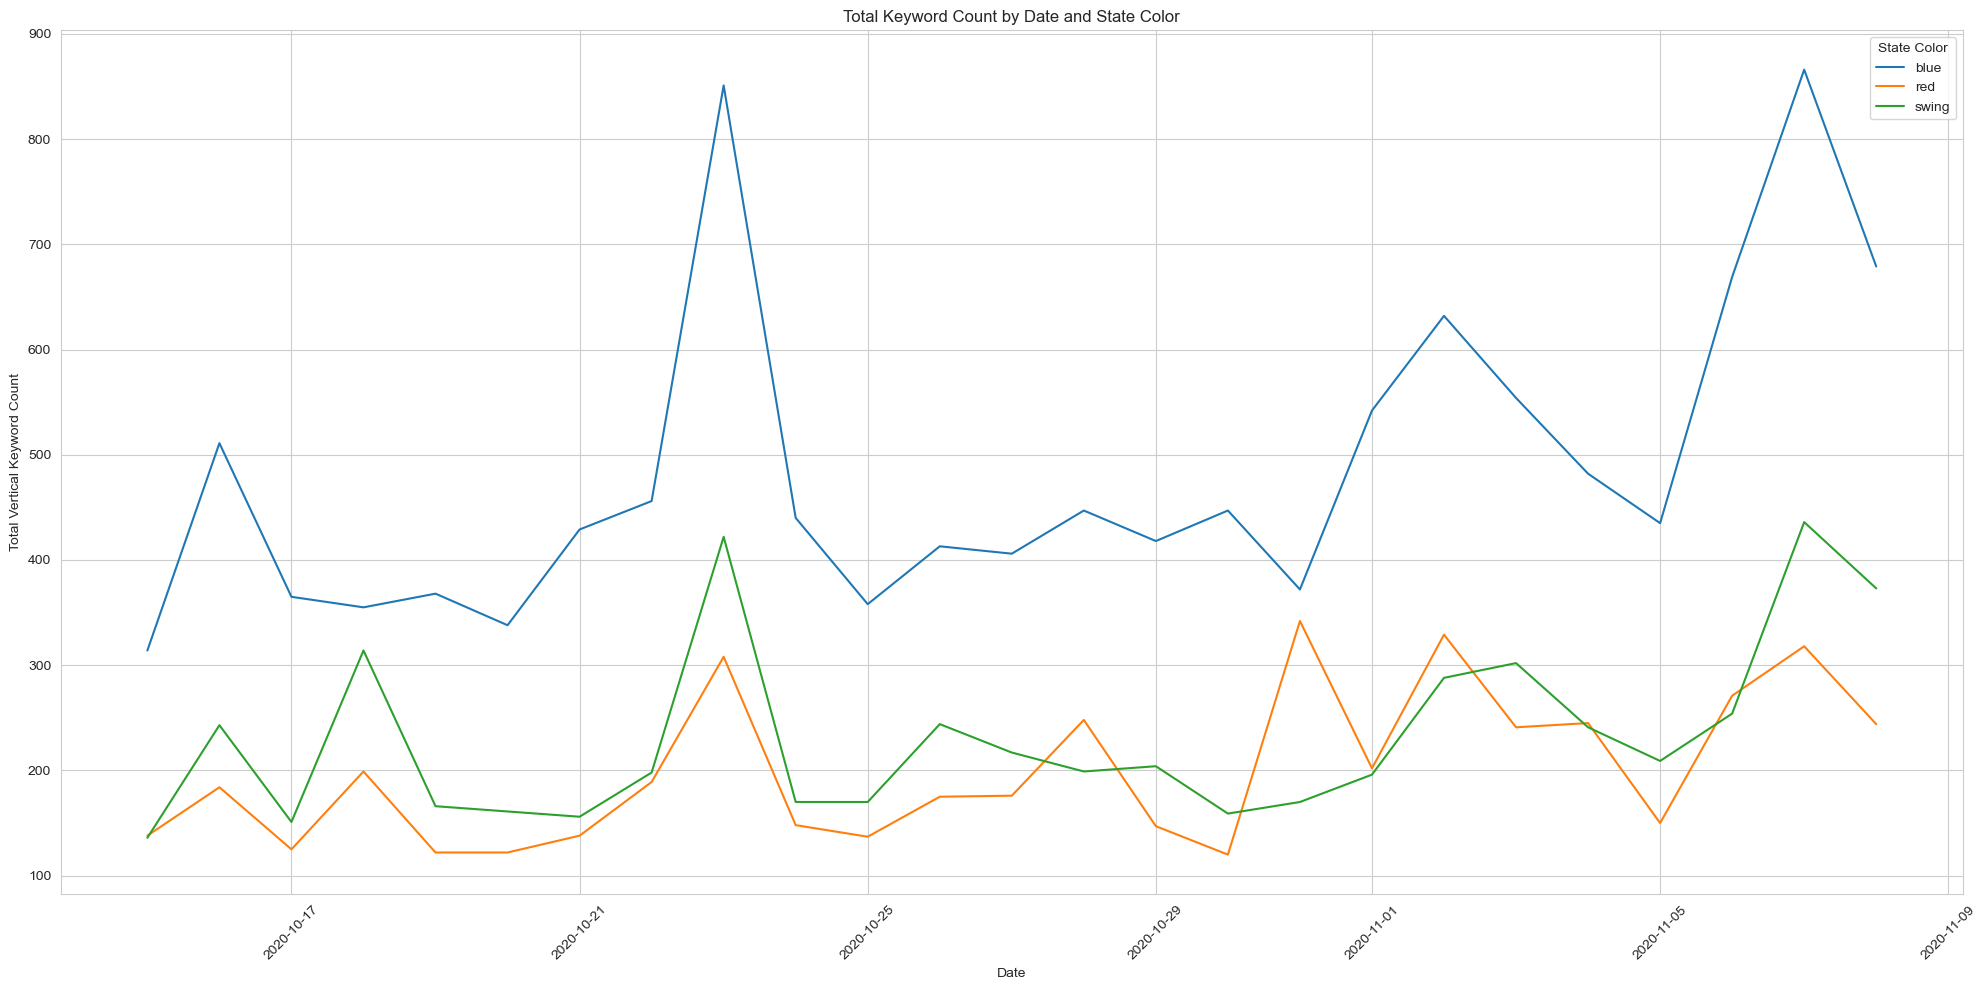

In [56]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the scatter plot
sns.lineplot(data=summed_keywords, x='created_at', y='sum', hue='state_color_2')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Vertical Keyword Count')
plt.title('Total Keyword Count by Date and State Color')
plt.xticks(rotation=45)
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


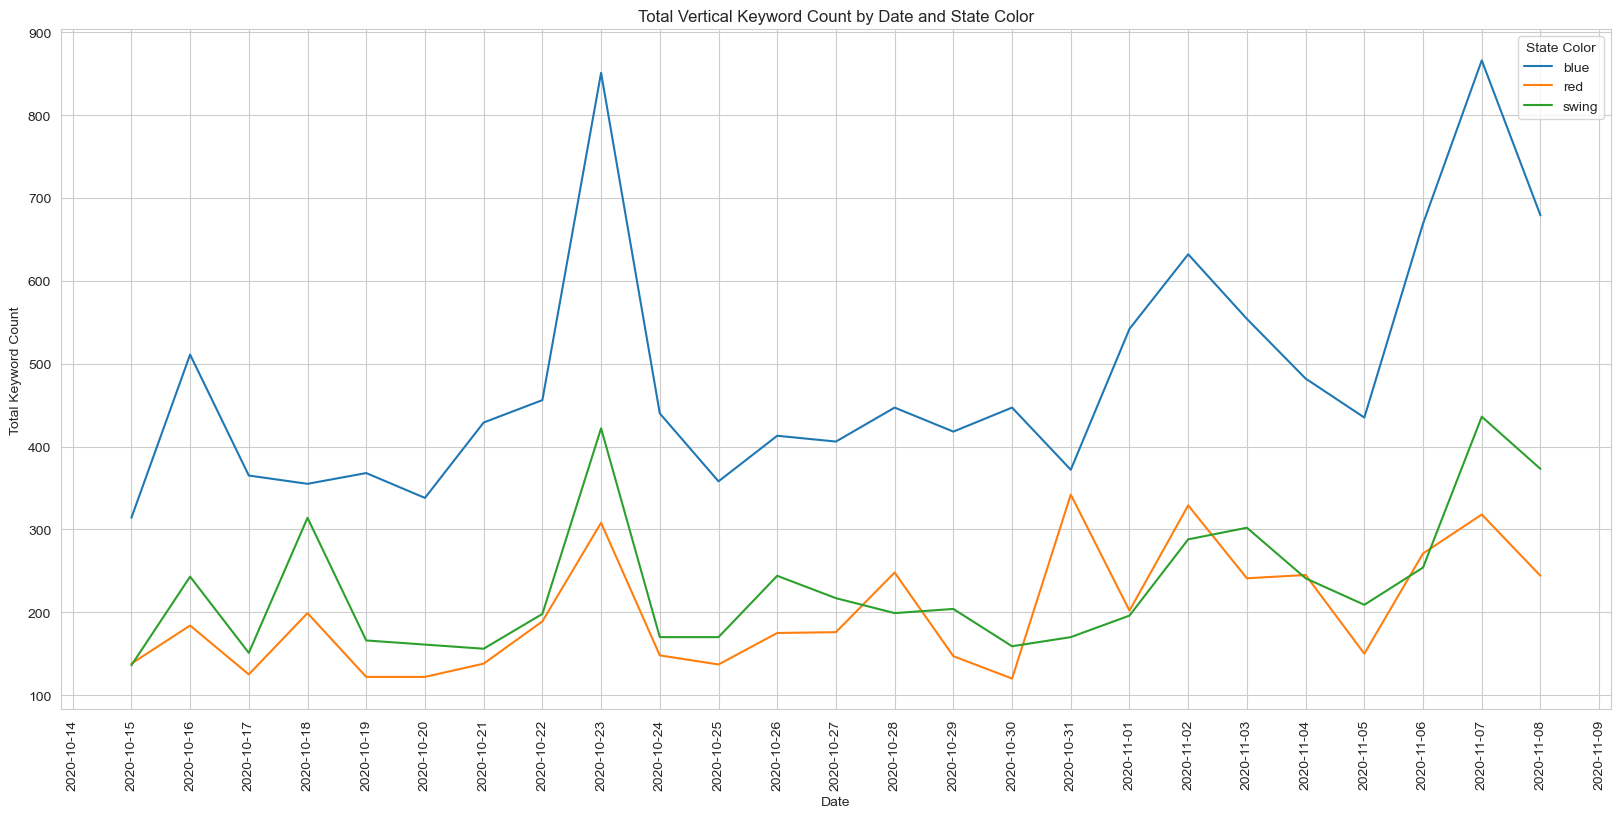

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the line plot
sns.lineplot(data=summed_keywords, x='created_at', y='sum', hue='state_color_2')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Keyword Count')
plt.title('Total Vertical Keyword Count by Date and State Color')

# Set x-axis major locator to every single day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis major formatter to show the date in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the date labels for better legibility
plt.xticks(rotation=90)

# Increase the bottom of the subplot to make the x-axis labels fit nicely
plt.subplots_adjust(bottom=0.2)

# Display the legend
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.show()


## Horizontal Values

In [58]:
df['horizontal_keywords'] = df['tweet'].apply(extract_keywords_2)

# Explode the DataFrame on the 'keywords' column
exploded_data = df.explode('horizontal_keywords')

keyword_counts_2 = exploded_data.groupby(['created_at', 'state_color_2', 'horizontal_keywords']).size().reset_index(name='count')

print(keyword_counts_2)

      created_at state_color_2 horizontal_keywords  count
0     2020-10-15          blue          appreciate      2
1     2020-10-15          blue         differences      7
2     2020-10-15          blue       environmental      2
3     2020-10-15          blue               equal     12
4     2020-10-15          blue            equality      4
...          ...           ...                 ...    ...
1113  2020-11-08         swing            tolerant      1
1114  2020-11-08         swing       understanding      4
1115  2020-11-08         swing              united    113
1116  2020-11-08         swing               unity     56
1117  2020-11-08         swing             welfare      2

[1118 rows x 4 columns]


In [59]:
import datetime
oct_15_data = keyword_counts_2[keyword_counts_2['created_at'] == datetime.date(2020, 10, 15)]
print(oct_15_data)

    created_at state_color_2 horizontal_keywords  count
0   2020-10-15          blue          appreciate      2
1   2020-10-15          blue         differences      7
2   2020-10-15          blue       environmental      2
3   2020-10-15          blue               equal     12
4   2020-10-15          blue            equality      4
5   2020-10-15          blue              equity      5
6   2020-10-15          blue          inequality      1
7   2020-10-15          blue             justice     29
8   2020-10-15          blue              nature     11
9   2020-10-15          blue               peace     47
10  2020-10-15          blue            peaceful      7
11  2020-10-15          blue           tolerance      3
12  2020-10-15          blue       understanding      4
13  2020-10-15          blue              united    106
14  2020-10-15          blue               unity     56
15  2020-10-15          blue             welfare      1
16  2020-10-15           red               equal

In [60]:
summed_keywords_2 = keyword_counts_2.groupby(['created_at', 'state_color_2'])['count'].sum().reset_index(name='sum')
print(summed_keywords_2)

    created_at state_color_2  sum
0   2020-10-15          blue  297
1   2020-10-15           red   84
2   2020-10-15         swing  118
3   2020-10-16          blue  359
4   2020-10-16           red  103
..         ...           ...  ...
70  2020-11-07           red  377
71  2020-11-07         swing  622
72  2020-11-08          blue  675
73  2020-11-08           red  254
74  2020-11-08         swing  297

[75 rows x 3 columns]


In [61]:
summi_keywords_2 = keyword_counts_2.groupby('state_color_2')['count'].sum()
print(summi_keywords_2)

state_color_2
blue     8465
red      3020
swing    4711
Name: count, dtype: int64


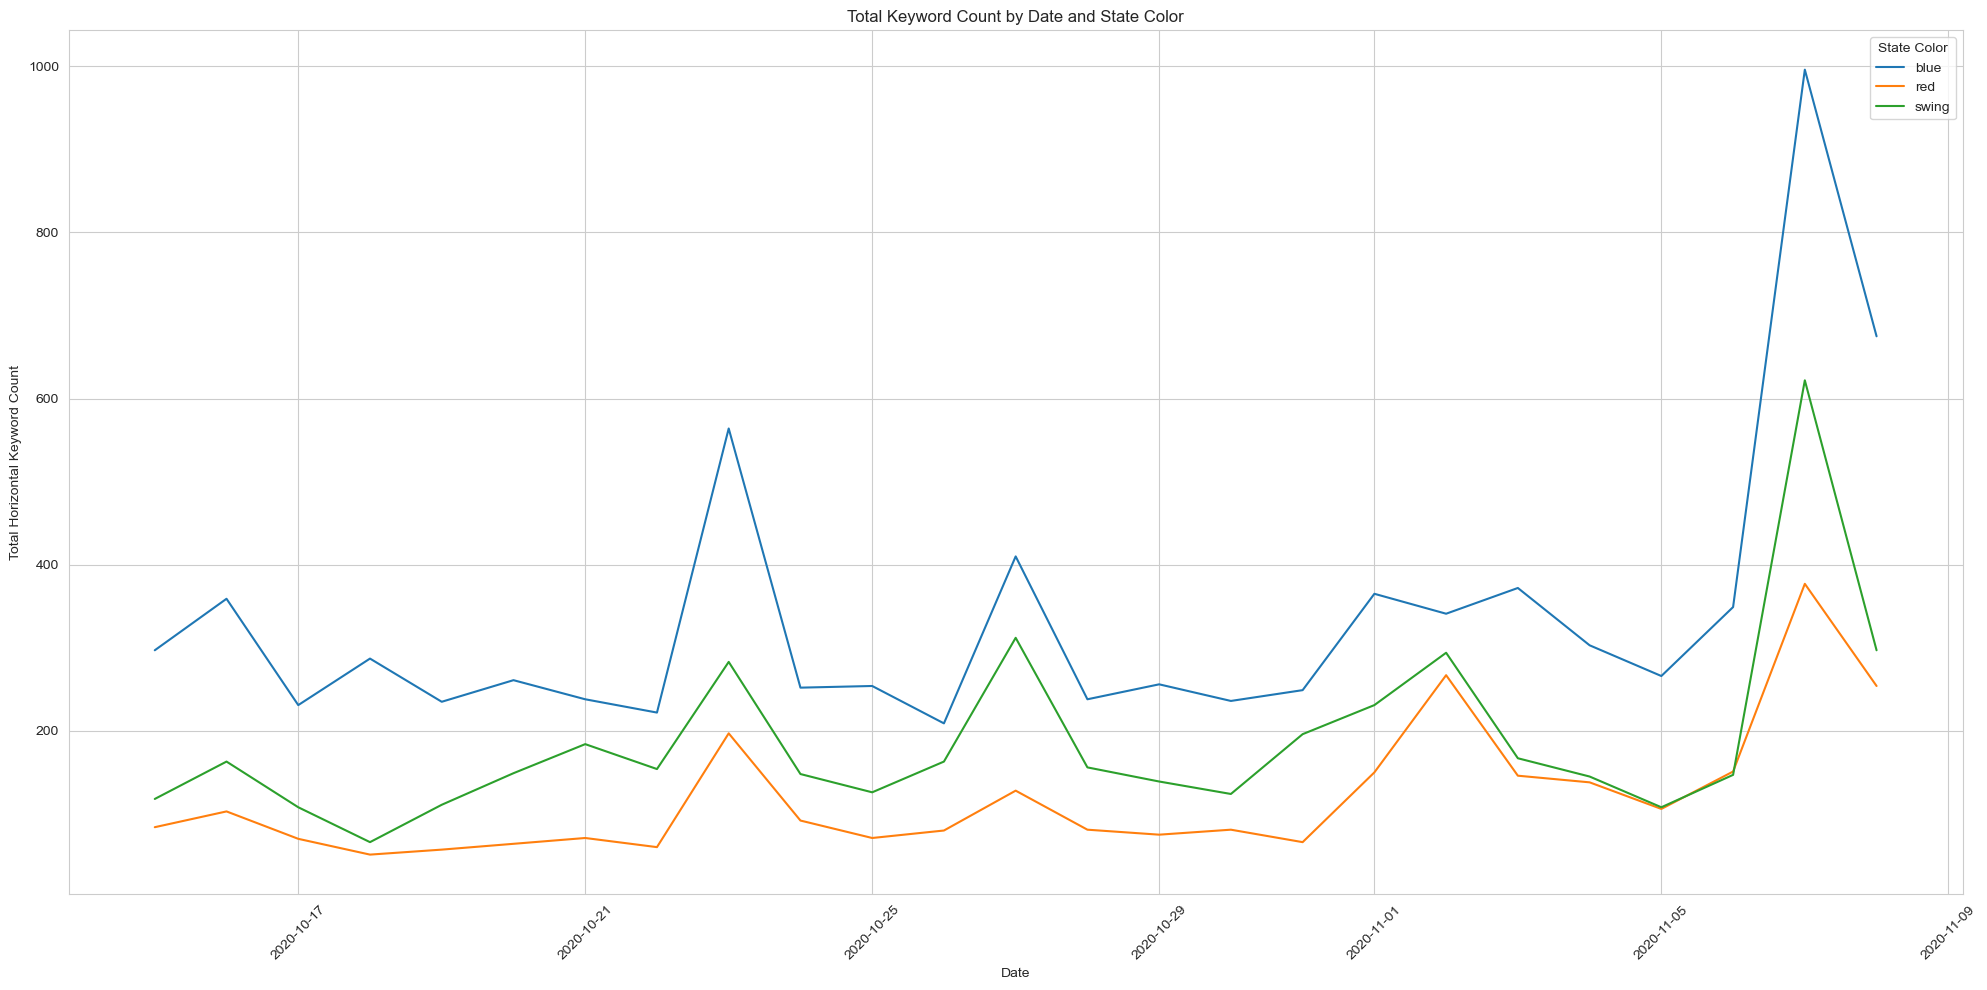

In [62]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the scatter plot
sns.lineplot(data=summed_keywords_2, x='created_at', y='sum', hue='state_color_2')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Horizontal Keyword Count')
plt.title('Total Keyword Count by Date and State Color')
plt.xticks(rotation=45)
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


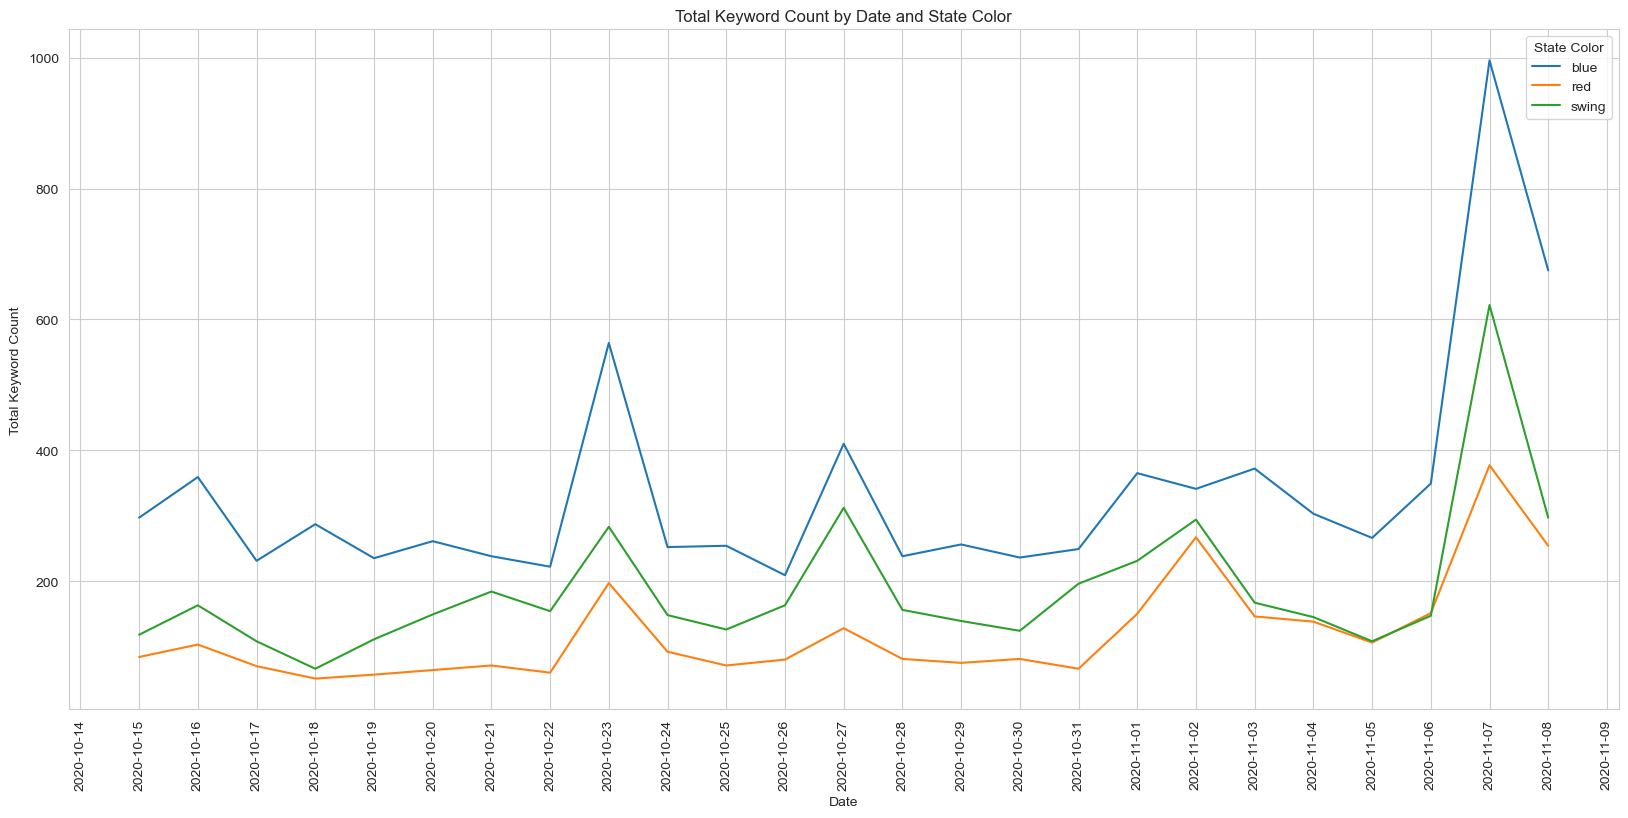

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

# Creating the line plot
sns.lineplot(data=summed_keywords_2, x='created_at', y='sum', hue='state_color_2')

# Setting the plot labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Total Keyword Count')
plt.title('Total Keyword Count by Date and State Color')

# Set x-axis major locator to every single day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis major formatter to show the date in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the date labels for better legibility
plt.xticks(rotation=90)

# Increase the bottom of the subplot to make the x-axis labels fit nicely
plt.subplots_adjust(bottom=0.2)

# Display the legend
plt.legend(title='State Color', loc='upper right')

# Display the plot
plt.show()


swing_state에 포함된 나라가 많아서, 2번 그래프 보다 keywords 숫자가 많음

## Graph

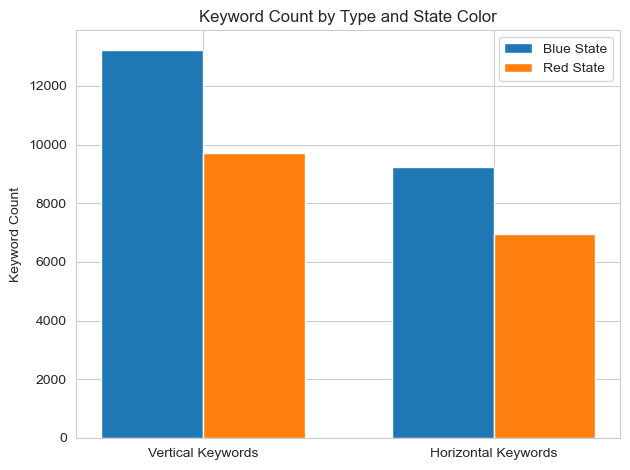

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터를 준비합니다
categories = ['Vertical Keywords', 'Horizontal Keywords']
blue_counts = [13230, 9238]  # vertical_summed_keywords와 horizontal_summed_keywords_2에서 'blue'에 대한 값
red_counts = [9714, 6958]    # vertical_summed_keywords와 horizontal_summed_keywords_2에서 'red'에 대한 값


bar_width = 0.35  # 막대의 너비
index = np.arange(len(categories))

# 막대 그래프를 생성
fig, ax = plt.subplots()
blue_bars = ax.bar(index, blue_counts, bar_width, label='Blue State')
red_bars = ax.bar(index + bar_width, red_counts, bar_width, label='Red State')

# 그래프에 레이블, 타이틀 및 범례를 추가
ax.set_ylabel('Keyword Count')
ax.set_title('Keyword Count by Type and State Color')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# 그래프를 화면에 표시합니다
plt.tight_layout()
plt.show()


## Swing Graph

In [65]:
summi_keywords

state_color_2
blue     12147
red       5018
swing     5779
Name: count, dtype: int64

In [66]:
summi_keywords_2

state_color_2
blue     8465
red      3020
swing    4711
Name: count, dtype: int64

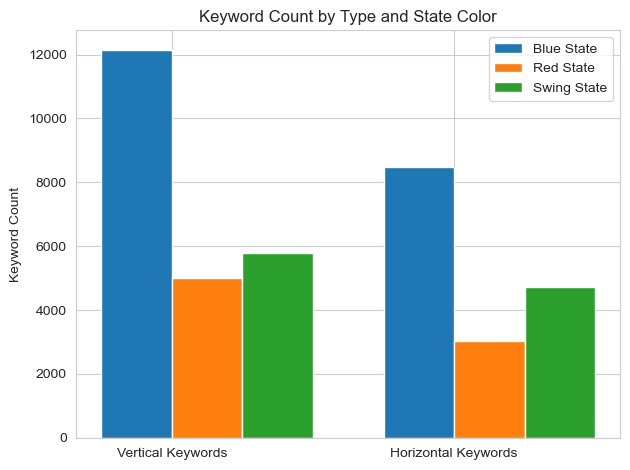

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터를 준비합니다
categories = ['Vertical Keywords', 'Horizontal Keywords']
blue_counts = [12147, 8465]  # vertical_summed_keywords와 horizontal_summed_keywords_2에서 'blue'에 대한 값
red_counts = [5018, 3020] 
swing_counts = [5779, 4711] # vertical_summed_keywords와 horizontal_summed_keywords_2에서 'red'에 대한 값


bar_width = 0.25  # 막대의 너비
index = np.arange(len(categories))

# 막대 그래프를 생성
fig, ax = plt.subplots()
blue_bars = ax.bar(index, blue_counts, bar_width, label='Blue State')
red_bars = ax.bar(index + bar_width, red_counts, bar_width, label='Red State')
swing_bars = ax.bar(index + bar_width + bar_width, swing_counts, bar_width, label='Swing State')

# 그래프에 레이블, 타이틀 및 범례를 추가
ax.set_ylabel('Keyword Count')
ax.set_title('Keyword Count by Type and State Color')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# 그래프를 화면에 표시합니다
plt.tight_layout()
plt.show()
